# Machine Learning: Accident Severity Prediction

In [1]:
import warnings

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## Change Directories

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/Users/mahahussain/Desktop/UK-Road-Accident-Analysis/UK-Road-Accident-Analysis/jupyter_notebooks'

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [4]:
current_dir = os.getcwd()
current_dir

'/Users/mahahussain/Desktop/UK-Road-Accident-Analysis/UK-Road-Accident-Analysis'

In [5]:
import pandas as pd 
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')

# Model 1 : Multinomial Logistic Regression

The aim of this ML model is to predict the severity of an accident based on the input features.

**The severity of an accident is classified into 3 categories:**
1. Fatal
2. Serious
3. Slight

Therefore, a multinomial logistic regression model will be used to predict the severity of an accident.

**Inputs:**
1. Data: 'filtered_accident_data_set.csv'

**Outputs:**

### Workflow plan:
1. Data Prepocessing
1. Split dataset into train and test set.
2. Create pipeline for feature selection, scaling, and model fitting.
3. Evaluate model with the test set.

## 1. Data Preprocessing

### Exploring data

In [6]:
df = pd.read_csv('filtered_accident_data_set.csv')

og_df = df.copy() # save the original data set in case we need it later

df.head()

,Index,Accident_Severity,Accident Date,Latitude,Light_Conditions,District Area,Longitude,Number_of_Casualties,Number_of_Vehicles,Road_Surface_Conditions,Road_Type,Urban_or_Rural_Area,Vehicle_Type
0,200720D003001,Slight,02-01-2019,52.513668,Darkness - lights lit,Birmingham,-1.901975,1,2,Wet or damp,Dual carriageway,Urban,Car
1,200720D003101,Slight,02-01-2019,52.502396,Daylight,Birmingham,-1.867086,1,2,Wet or damp,Single carriageway,Urban,Car
2,200720D003802,Serious,03-01-2019,52.563201,Daylight,Birmingham,-1.822793,1,1,Dry,Single carriageway,Urban,Car
3,200720D005801,Slight,02-01-2019,52.493431,Daylight,Birmingham,-1.818507,1,2,Wet or damp,Dual carriageway,Urban,Car
4,200720D005901,Slight,05-01-2019,52.510805,Darkness - lights lit,Birmingham,-1.834202,1,3,Dry,Dual carriageway,Urban,Car


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32657 entries, 0 to 32656
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Index                    32657 non-null  object 
 1   Accident_Severity        32657 non-null  object 
 2   Accident Date            32657 non-null  object 
 3   Latitude                 32657 non-null  float64
 4   Light_Conditions         32657 non-null  object 
 5   District Area            32657 non-null  object 
 6   Longitude                32657 non-null  float64
 7   Number_of_Casualties     32657 non-null  int64  
 8   Number_of_Vehicles       32657 non-null  int64  
 9   Road_Surface_Conditions  32657 non-null  object 
 10  Road_Type                32657 non-null  object 
 11  Urban_or_Rural_Area      32657 non-null  object 
 12  Vehicle_Type             32657 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 3.2+ MB


### Preprocessing checks

In [8]:
# print num of duplicate rows
print( f'there are ',df.duplicated().sum(), ' duplicate rows')


there are  0  duplicate rows


<Axes: >

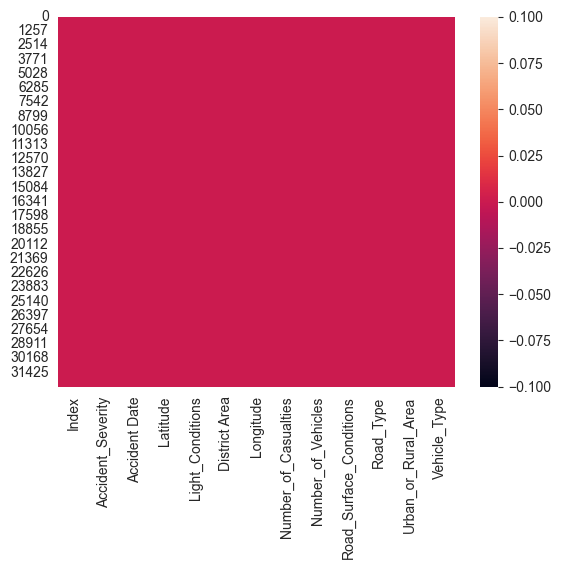

In [9]:
# Heatmap to check missing values
sns.heatmap(df.isnull())

Accident index has no relevance on the prediction of accident severity, therefore this column will be dropped.

In [10]:
df.drop(['Index'], axis=1, inplace=True)

# verify if the column was dropped
df.head()

,Accident_Severity,Accident Date,Latitude,Light_Conditions,District Area,Longitude,Number_of_Casualties,Number_of_Vehicles,Road_Surface_Conditions,Road_Type,Urban_or_Rural_Area,Vehicle_Type
0,Slight,02-01-2019,52.513668,Darkness - lights lit,Birmingham,-1.901975,1,2,Wet or damp,Dual carriageway,Urban,Car
1,Slight,02-01-2019,52.502396,Daylight,Birmingham,-1.867086,1,2,Wet or damp,Single carriageway,Urban,Car
2,Serious,03-01-2019,52.563201,Daylight,Birmingham,-1.822793,1,1,Dry,Single carriageway,Urban,Car
3,Slight,02-01-2019,52.493431,Daylight,Birmingham,-1.818507,1,2,Wet or damp,Dual carriageway,Urban,Car
4,Slight,05-01-2019,52.510805,Darkness - lights lit,Birmingham,-1.834202,1,3,Dry,Dual carriageway,Urban,Car


### Defining target variable

Our chosen target variable is the accident severity. Our ML task will be classification.

In [11]:
df['Accident_Severity'].value_counts()

Accident_Severity
Slight     28566
Serious     3818
Fatal        273
Name: count, dtype: int64

In [12]:
from sklearn.preprocessing import LabelEncoder

# Initialise the LabelEncoder
label_encoder = LabelEncoder()

# Encode the target variable (Accident_Severity)
df['Accident_Severity'] = label_encoder.fit_transform(df['Accident_Severity'])

# Check the encoding
print(df['Accident_Severity'].value_counts())


Accident_Severity
2    28566
1     3818
0      273
Name: count, dtype: int64


## 2. Pipeline Setup

In [13]:
# import pipeline libraries
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# standard scaler --> scales numerical columns 
# one hot encoder --> encodes categorical columns
from sklearn.preprocessing import StandardScaler, OneHotEncoder 

# import model libraries
from sklearn.linear_model import LogisticRegression

# import train test split
from sklearn.model_selection import train_test_split

- standard scaler for numerical columns
- one hot encoder for categorical columns

In [14]:
# convert Accident Date to datetime
df['Accident Date'] = pd.to_datetime(df['Accident Date'], dayfirst=True)

# create new columns for year, month, day, weekday
df['Year'] = df['Accident Date'].dt.year
df['Month'] = df['Accident Date'].dt.month
df['Day'] = df['Accident Date'].dt.day
df['Weekday'] = df['Accident Date'].dt.weekday # 0 = Monday, 6 = Sunday

# drop Accident Date
df.drop('Accident Date', axis=1, inplace=True)

# shuffle the data set
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# split features (X) and target variable (y)
X_train, X_test, y_train, y_test = train_test_split(df.drop('Accident_Severity', axis=1), df['Accident_Severity'], test_size=0.2, random_state=42)

#test set = 20% of the data set
#train set = 80% of the data set

# print the shape of the sets
print('Training data set: ', X_train.shape, 
        '- y_train: ', y_train.shape, '\n'
        'Testing data set: ', X_test.shape,
        '- y_test: ', y_test.shape
        )

Training data set:  (26125, 14) - y_train:  (26125,) 
Testing data set:  (6532, 14) - y_test:  (6532,)


In [15]:
# Automatically define numerical and categorical columns from X_train
num = X_train.select_dtypes(include=np.number).columns.tolist()
cat = X_train.select_dtypes(include='object').columns.tolist()

# create transformer for column preprocessing
# standard scaler for numerical columns
# one hot encoder for categorical columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num),
        ('cat', OneHotEncoder(), cat)
    ]
)

### Model selection

We will use a multinomial logistic regression model.
- Our target variable (Accident Severity) has more than two categories (e.g., Slight, Serious, Fatal), so we're dealing with a multiclass classification problem.


**Preprocessing:**

- Numerical data (like numbers for location, casualties, etc.) is adjusted so they’re on the same scale (so no feature is too big or too small compared to others).
- Categorical data (like light conditions, road type) is converted into yes/no (1/0) columns, making it easier for the model to understand.

**Logistic Regression:**

- The model that will predict accident severity. It handles multiple types of severity (multi-class) and is set to run longer (max_iter=500) to make sure it gives a good result.

In [16]:
# create a pipeline with the preprocessor and the model

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500, class_weight='balanced'))
])

# class_weight='balanced' to handle imbalanced classes as Slight is the majority class

# print pipeline steps
pipe.steps

[('preprocessor',
  ColumnTransformer(transformers=[('num', StandardScaler(),
                                   ['Latitude', 'Longitude',
                                    'Number_of_Casualties', 'Number_of_Vehicles',
                                    'Year', 'Month', 'Day', 'Weekday']),
                                  ('cat', OneHotEncoder(),
                                   ['Light_Conditions', 'District Area',
                                    'Road_Surface_Conditions', 'Road_Type',
                                    'Urban_or_Rural_Area', 'Vehicle_Type'])])),
 ('model',
  LogisticRegression(class_weight='balanced', max_iter=500,
                     multi_class='multinomial'))]

### Train the model + Predict on the test set

In [17]:
# train the model
pipe.fit(X_train, y_train)

# predict the target variable
y_pred = pipe.predict(X_test)

## 4. Model Evaluation

              precision    recall  f1-score   support

           0       0.02      0.59      0.04        59
           1       0.18      0.39      0.25       780
           2       0.92      0.52      0.66      5693

    accuracy                           0.50      6532
   macro avg       0.37      0.50      0.32      6532
weighted avg       0.83      0.50      0.61      6532

Predicted     0     1     2
Actual                     
0            35    12    12
1           241   307   232
2          1356  1400  2937


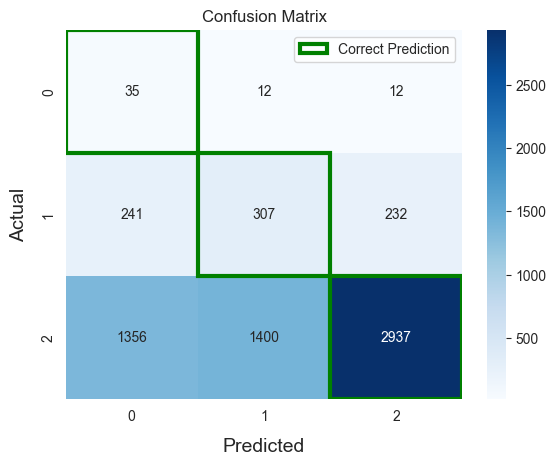

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

# print classification report
print(classification_report(y_test, y_pred))

# print confusion matrix in a more readable format
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns=np.unique(y_test), index = np.unique(y_test))
cm_df.index.name = 'Actual'
cm_df.columns.name = 'Predicted'
print(cm_df)

import matplotlib.pyplot as plt
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# replace numbers for class names with the actual class names
plt.xticks(ticks=np.arange(3)+0.5, labels=np.unique(y_test))
plt.yticks(ticks=np.arange(3)+0.5, labels=np.unique(y_test))

# green border around the correct prediction squares
for i in range(3):
    plt.gca().add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='green', linewidth=3))
plt.legend(['Correct Prediction'], loc='upper right')



plt.xlabel('Predicted', fontsize=14, labelpad=10)
plt.ylabel('Actual', fontsize=14, labelpad=10)
plt.title('Confusion Matrix')
plt.show()




- **Fatal**: Recall is high (0.59), but precision is extremely low (0.02). This means the model manages to identify some "Fatal" accidents, but it's predicting "Fatal" too often when it shouldn't, leading to a high number of false positives.

- **Serious**: Both precision (0.18) and recall (0.39) are low, indicating the model struggles to correctly classify "Serious" accidents. Many "Serious" cases are getting misclassified as "Slight" or "Fatal".

- **Slight**: Precision (0.92) is high, meaning the model is good at predicting "Slight" accidents. However, the recall (0.52) is lower, suggesting it misses a notable portion of "Slight" accidents, likely misclassifying them as "Serious" or "Fatal".

- **Accuracy**: The overall accuracy is 50%, which suggests the model is heavily biased towards predicting "Slight" accidents, given their large presence in the dataset.

### Confusion Matrix:

- **"Fatal" accidents**: Many are misclassified as "Serious" (12) or "Slight" (12), despite some being correctly predicted (35).
- **"Serious" accidents**: These are often misclassified as "Slight" (232), though a fair amount are correctly predicted (307).
- **"Slight" accidents**: Many are correctly identified (2937), but a significant number are misclassified as "Serious" (1400) or "Fatal" (1356).


## 5. Challenges and Areas for Improvement

- Imbalanced Dataset: The model's bias toward predicting "Slight" accidents is a direct result of the imbalance in the dataset, where "Slight" accidents vastly outnumber "Fatal" and "Serious" accidents.

- Address Data Imbalance: We plan to implement SMOTE (Synthetic Minority Over-sampling Technique) to generate synthetic samples for the minority classes ("Serious" and "Fatal"), which should help improve model performance on these categories.

## 6. SMOTE: Synthetic Minority Over-sampling Technique


SMOTE powerful technique for handling class imbalance by creating synthetic examples for the minority classes. In our case, for `serious` and `fatal`.

In [19]:
# import the imbalanced-learn library
from imblearn.pipeline import Pipeline  # Use the imbalanced-learn pipeline
from imblearn.over_sampling import SMOTE


In [20]:
# Shuffle the data set
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split features (X) and target variable (y)
X_train, X_test, y_train, y_test = train_test_split(df.drop('Accident_Severity', axis=1), df['Accident_Severity'], test_size=0.2, random_state=42)

# Automatically define numerical and categorical columns from X_train
num = X_train.select_dtypes(include=np.number).columns.tolist()
cat = X_train.select_dtypes(include='object').columns.tolist()


In [21]:
# using same preprocessor as before

# Create a pipeline with SMOTE, preprocessor, and the model
smote_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Column preprocessing
    ('smote', SMOTE(random_state=42)),  # Apply SMOTE inside the pipeline
    ('model', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, class_weight='balanced'))  # Logistic Regression model
])

# Print pipeline steps to verify
print(smote_pipeline.steps)

[('preprocessor', ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['Latitude', 'Longitude',
                                  'Number_of_Casualties', 'Number_of_Vehicles',
                                  'Year', 'Month', 'Day', 'Weekday']),
                                ('cat', OneHotEncoder(),
                                 ['Light_Conditions', 'District Area',
                                  'Road_Surface_Conditions', 'Road_Type',
                                  'Urban_or_Rural_Area', 'Vehicle_Type'])])), ('smote', SMOTE(random_state=42)), ('model', LogisticRegression(class_weight='balanced', max_iter=1000,
                   multi_class='multinomial'))]


In [22]:
# Train the model and make predictions
# Train the model
smote_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = smote_pipeline.predict(X_test)

              precision    recall  f1-score   support

           0       0.02      0.54      0.04        63
           1       0.15      0.36      0.22       777
           2       0.91      0.49      0.64      5692

    accuracy                           0.47      6532
   macro avg       0.36      0.46      0.30      6532
weighted avg       0.82      0.47      0.58      6532

Predicted     0     1     2
Actual                     
0            34    12    17
1           251   282   244
2          1389  1530  2773


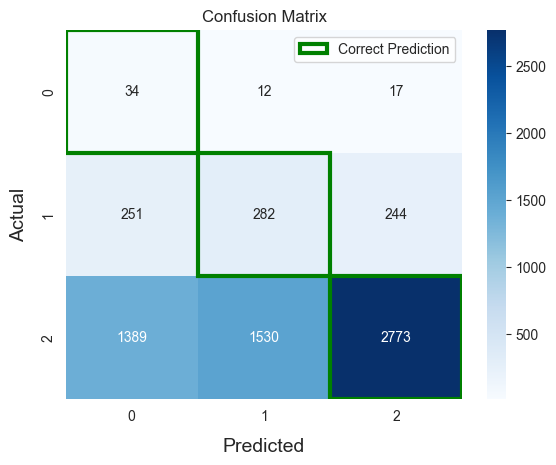

In [23]:

# print classification report
print(classification_report(y_test, y_pred))

# print confusion matrix in a more readable format
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns=np.unique(y_test), index = np.unique(y_test))
cm_df.index.name = 'Actual'
cm_df.columns.name = 'Predicted'
print(cm_df)

import matplotlib.pyplot as plt
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# replace numbers for class names with the actual class names
plt.xticks(ticks=np.arange(3)+0.5, labels=np.unique(y_test))
plt.yticks(ticks=np.arange(3)+0.5, labels=np.unique(y_test))

# green border around the correct prediction squares
for i in range(3):
    plt.gca().add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='green', linewidth=3))
plt.legend(['Correct Prediction'], loc='upper right')



plt.xlabel('Predicted', fontsize=14, labelpad=10)
plt.ylabel('Actual', fontsize=14, labelpad=10)
plt.title('Confusion Matrix')
plt.show()

**Accuracy**: 47% - reduced...


**Overall Performance**:
- **Fatal**: Recall improved to 0.54, but precision remains very low (0.02).
- **Serious**: Precision and recall still low (0.15 and 0.36), indicating poor prediction for this class.
- **Slight**: Strong precision (0.91) and F1-score (0.64), but the model heavily favors this majority class.



## 7. Next Steps

- Model Limitations: Although Multinomial Logistic Regression is suitable for multi-class problems, it may not be the best model for dealing with the imbalanced data. The low performance for "Serious" and "Fatal" accidents suggests that a more complex model may be needed.

- Experiment with More Complex Models: After addressing the class imbalance, we will experiment with more sophisticated models, such as Random Forest, which can better capture non-linear relationships in the data and may perform better in multi-class settings.

# Model 2 : Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier

### Without SMOTE

Creating a new pipeline with the same preprocessing steps as before.

In [25]:
# Create pipeline with preprocessor and Random Forest model

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Column preprocessing
    ('model', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))  # Random Forest model
])

# Print pipeline steps to verify
print(rf_pipeline.steps)

[('preprocessor', ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['Latitude', 'Longitude',
                                  'Number_of_Casualties', 'Number_of_Vehicles',
                                  'Year', 'Month', 'Day', 'Weekday']),
                                ('cat', OneHotEncoder(),
                                 ['Light_Conditions', 'District Area',
                                  'Road_Surface_Conditions', 'Road_Type',
                                  'Urban_or_Rural_Area', 'Vehicle_Type'])])), ('model', RandomForestClassifier(class_weight='balanced', random_state=42))]


In [26]:
# train and predict

# train the model
rf_pipeline.fit(X_train, y_train)

# make predictions
y_pred_rf = rf_pipeline.predict(X_test)

Classification Report - Random Forest
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        63
           1       0.14      0.00      0.00       777
           2       0.87      1.00      0.93      5692

    accuracy                           0.87      6532
   macro avg       0.34      0.33      0.31      6532
weighted avg       0.78      0.87      0.81      6532

Predicted  0  1     2
Actual               
0          0  0    63
1          0  1   776
2          0  6  5686


/Users/mahahussain/Desktop/UK-Road-Accident-Analysis/UK-Road-Accident-Analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mahahussain/Desktop/UK-Road-Accident-Analysis/UK-Road-Accident-Analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mahahussain/Desktop/UK-Road-Accident-Analysis/UK-Road-Accident-Analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being s

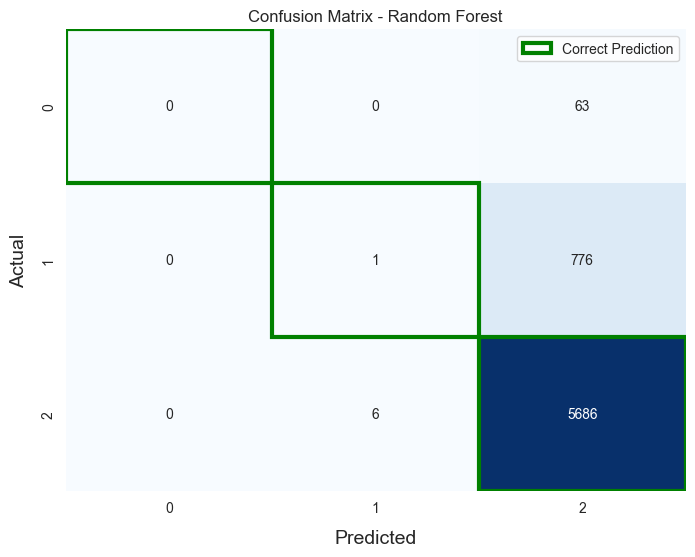

In [27]:
# Print classification report for Random Forest
print("Classification Report - Random Forest")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_df_rf = pd.DataFrame(cm_rf, columns=np.unique(y_test), index=np.unique(y_test))
cm_df_rf.index.name = 'Actual'
cm_df_rf.columns.name = 'Predicted'
print(cm_df_rf)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False)

# Replace numbers for class names
plt.xticks(ticks=np.arange(3)+0.5, labels=np.unique(y_test))
plt.yticks(ticks=np.arange(3)+0.5, labels=np.unique(y_test))

# Green border around correct prediction squares
for i in range(3):
    plt.gca().add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='green', linewidth=3))
plt.legend(['Correct Prediction'], loc='upper right')

plt.xlabel('Predicted', fontsize=14, labelpad=10)
plt.ylabel('Actual', fontsize=14, labelpad=10)
plt.title('Confusion Matrix - Random Forest')
plt.show()

- **Accuracy**: 87%
- **Class-wise Performance**:
  - **Fatal**: Precision, Recall, and F1-score all at 0.00 (No correct predictions for fatal accidents).
  - **Serious**: Precision = 0.14, Recall = 0.00, F1-score = 0.00 (Very poor performance, likely due to class imbalance).
  - **Slight**: Precision = 0.87, Recall = 1.00, F1-score = 0.93 (Strong performance on the majority class).

### Key Insights:
- The model shows a strong performance on **Slight** accidents but fails to predict **Fatal** and **Serious** accidents accurately, mainly due to the class imbalance.
- **SMOTE** could help improve performance on the minority classes (Fatal and Serious).

### With SMOTE

In [28]:
# Create a pipeline with SMOTE and RandomForest
rf_smote_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),  # Apply SMOTE to oversample the minority class
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
])


In [29]:
# Fit the model
rf_smote_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_rf_smote = rf_smote_pipeline.predict(X_test)

Classification Report - Random Forest w/ SMOTE
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        63
           1       0.22      0.06      0.10       777
           2       0.88      0.97      0.92      5692

    accuracy                           0.85      6532
   macro avg       0.37      0.34      0.34      6532
weighted avg       0.79      0.85      0.81      6532

Predicted  0    1     2
Actual                 
0          0    3    60
1          1   49   727
2          6  170  5516


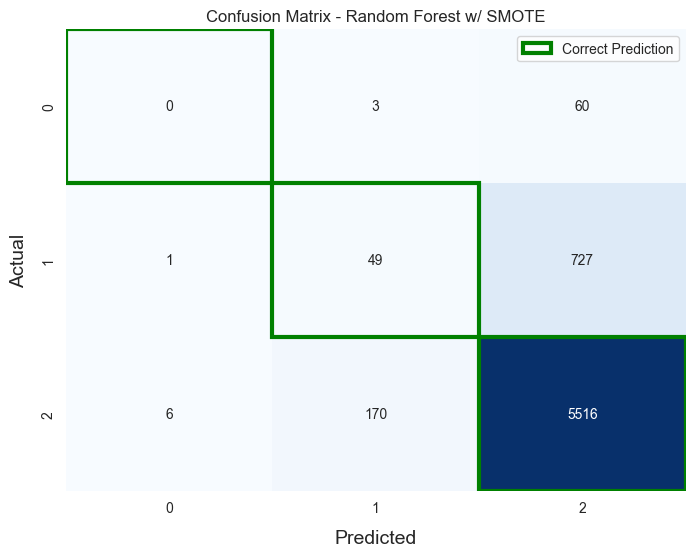

In [30]:
# Print classification report for Random Forest
print("Classification Report - Random Forest w/ SMOTE")
print(classification_report(y_test, y_pred_rf_smote))

# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf_smote)
cm_df_rf = pd.DataFrame(cm_rf, columns=np.unique(y_test), index=np.unique(y_test))
cm_df_rf.index.name = 'Actual'
cm_df_rf.columns.name = 'Predicted'
print(cm_df_rf)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False)

# Replace numbers for class names
plt.xticks(ticks=np.arange(3)+0.5, labels=np.unique(y_test))
plt.yticks(ticks=np.arange(3)+0.5, labels=np.unique(y_test))

# Green border around correct prediction squares
for i in range(3):
    plt.gca().add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='green', linewidth=3))
plt.legend(['Correct Prediction'], loc='upper right')

plt.xlabel('Predicted', fontsize=14, labelpad=10)
plt.ylabel('Actual', fontsize=14, labelpad=10)
plt.title('Confusion Matrix - Random Forest w/ SMOTE')
plt.show()

- **Accuracy**: 85%
- **Class-wise Performance**:
  - **Fatal**: Precision, Recall, and F1-score all at 0.00 (No correct predictions for fatal accidents).
  - **Serious**: Precision = 0.22, Recall = 0.06, F1-score = 0.10 (Some improvement in predictions for serious accidents but still poor overall performance).
  - **Slight**: Precision = 0.88, Recall = 0.97, F1-score = 0.92 (Strong performance on the majority class).

### Key Insights:
- **SMOTE** improved the model's ability to predict **Serious** accidents, but **Fatal** accidents remain largely unpredicted.
- The model still performs best on **Slight** accidents, and further optimisation (e.g., hyperparameter tuning, advanced balancing techniques) might be required to improve prediction for minority classes.

# Multinomial Logistic Regression Vs. Random Forest

Comparison of model performance, courtesy of ChatGPT:

#### Logistic Regression (without SMOTE)
- **Accuracy**: 50%
- **Precision**: Low precision for both Fatal and Serious categories, but high precision for Slight.
- **Recall**: High recall for Fatal but low for Serious and Slight categories.
- **F1-Score**: The F1-score is higher for Slight but lower for the other two categories.

#### Logistic Regression (with SMOTE)
- **Accuracy**: 47%
- **Precision**: Slightly lower than without SMOTE, with still very low precision for Fatal and Serious.
- **Recall**: Recall is higher for Fatal, but still lower for Serious and Slight compared to the non-SMOTE model.
- **F1-Score**: The F1-score is still highest for Slight, but lower than in the non-SMOTE case.

#### Random Forest (without SMOTE)
- **Accuracy**: 87%
- **Precision**: Precision for Fatal and Serious is extremely low (0.00), likely due to the model predicting mostly Slight accidents.
- **Recall**: Perfect recall for Slight (1.00), but 0.00 for Fatal and Serious categories.
- **F1-Score**: Very high F1-score for Slight but 0.00 for the other two categories.

#### Random Forest (with SMOTE)
- **Accuracy**: 85%
- **Precision**: Precision for Fatal is 0.00, for Serious is low (0.22), and high for Slight (0.88).
- **Recall**: Recall for Fatal is 0.00, for Serious is very low (0.06), but very high for Slight (0.97).
- **F1-Score**: The F1-score is excellent for Slight (0.92) but very poor for Fatal (0.00) and Serious (0.10).
- **Confusion Matrix Insight**: The model continues to heavily misclassify Fatal and Serious accidents as Slight, even after applying SMOTE. Only slight improvements are seen in the Serious category compared to without SMOTE.

### Key Observations:
- **Logistic Regression**: The model performs decently on the Slight category, but the performance on Fatal and Serious is poor. This is likely due to the class imbalance in the data. SMOTE helps to some extent but does not entirely solve the issue.
- **Random Forest**: This model shows excellent performance in terms of accuracy (87%) but fails to predict Fatal and Serious accidents, only predicting Slight accidents. This suggests that the model might be biased toward the majority class (Slight).
- **Class Imbalance**: Your dataset is highly imbalanced, with Slight accidents being much more frequent than Serious and Fatal ones. SMOTE helps balance the dataset by oversampling the minority classes, but it's not fully solving the issue with random forest.

### Next Steps
 **Hyperparameter Tuning with Grid Search CV**:
   - Implement **Grid Search with Cross-Validation (GridSearchCV)** to fine-tune hyperparameters such as `n_estimators`, `max_depth`, `min_samples_split`, and `class_weight`.


# Grid Search on Random Forest w/ SMOTE

In [31]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid with fewer values
param_grid = {
    'rf__n_estimators': [100, 200],          # Two values
    'rf__max_depth': [None, 10],              # Two values
    'rf__min_samples_split': [2, 5],          # Two values
    'rf__min_samples_leaf': [1, 2],           # Two values
    'rf__class_weight': ['balanced']         # Only testing 'balanced'
}

# GridSearchCV setup
grid_search = GridSearchCV(estimator=rf_smote_pipeline, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

In [32]:
# Fit GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[CV] END rf__class_weight=balanced, rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  39.6s
[CV] END rf__class_weight=balanced, rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  39.7s
[CV] END rf__class_weight=balanced, rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  40.1s
[CV] END rf__class_weight=balanced, rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  40.3s
[CV] END rf__class_weight=balanced, rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  40.2s
[CV] END rf__class_weight=balanced, rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100; total time=  34.0s
[CV] END rf__class_weight=balanced, rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=10

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Latitude',
                                                                          'Longitude',
                                                                          'Number_of_Casualties',
                                                                          'Number_of_Vehicles',
                                                                          'Year',
                                                                          'Month',
                                                                          'Day',
                                                                          'Weekday']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['Light_Conditions',
                                                                          'District '
                                                                          'Area',
                                                                          'Road_Surface_Conditions',
                                                                          'Road_Type',
                                                                          'Urban_or_Rural_Area',
                                                                          'Vehicle_Type'])])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__class_weight': ['balanced'],
                         'rf__max_depth': [None, 10],
                         'rf__min_samples_leaf': [1, 2],
                         'rf__min_samples_split': [2, 5],
                         'rf__n_estimators': [100, 200]},
             scoring='accuracy', verbose=2)

In [33]:
# Best parameters from GridSearchCV
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'rf__class_weight': 'balanced', 'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 200}


In [34]:
# Evaluate the tuned model
best_rf_model = grid_search.best_estimator_

In [35]:
# Make predictions with the best model
y_pred_rf_tuned = best_rf_model.predict(X_test)

Classification Report - Random Forest with Hyperparameter Tuning
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        63
           1       0.24      0.06      0.10       777
           2       0.88      0.97      0.92      5692

    accuracy                           0.86      6532
   macro avg       0.37      0.34      0.34      6532
weighted avg       0.79      0.86      0.81      6532

Predicted  0    1     2
Actual                 
0          0    2    61
1          1   47   729
2          5  147  5540


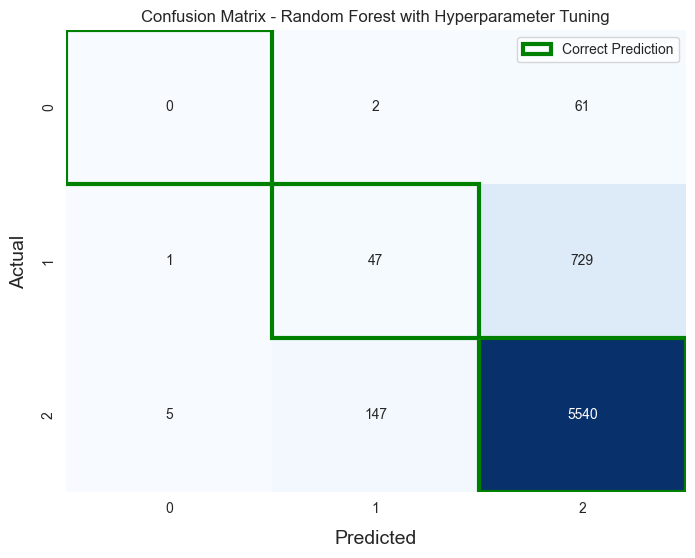

In [36]:
# Print classification report for Random Forest with tuning
print("Classification Report - Random Forest with Hyperparameter Tuning")
print(classification_report(y_test, y_pred_rf_tuned))

# Confusion Matrix
cm_rf_tuned = confusion_matrix(y_test, y_pred_rf_tuned)
cm_df_rf_tuned = pd.DataFrame(cm_rf_tuned, columns=np.unique(y_test), index=np.unique(y_test))
cm_df_rf_tuned.index.name = 'Actual'
cm_df_rf_tuned.columns.name = 'Predicted'
print(cm_df_rf_tuned)

# Plot confusion matrix for tuned model
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf_tuned, annot=True, fmt='d', cmap='Blues', cbar=False)

# Replace numbers for class names
plt.xticks(ticks=np.arange(3)+0.5, labels=np.unique(y_test))
plt.yticks(ticks=np.arange(3)+0.5, labels=np.unique(y_test))

# Green border around correct prediction squares
for i in range(3):
    plt.gca().add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='green', linewidth=3))
plt.legend(['Correct Prediction'], loc='upper right')

plt.xlabel('Predicted', fontsize=14, labelpad=10)
plt.ylabel('Actual', fontsize=14, labelpad=10)
plt.title('Confusion Matrix - Random Forest with Hyperparameter Tuning')
plt.show()

**Key Insights:**
- Fatal Class (63 instances): The model fails to predict the Fatal class (precision and recall are both 0.00), which suggests that the model is not learning to classify it properly.

- Serious Class (777 instances): The model has low precision and recall for the Serious class (precision of 0.24 and recall of 0.06), indicating that it’s not predicting this class well either.

- Slight Class (5692 instances): The model performs well here (precision of 0.88, recall of 0.97), but this class is overwhelming compared to the other two. This leads to the model focusing more on predicting the Slight class due to its large number of instances.

# Model 3: XG Boost

In [37]:
import xgboost as xgb

smote = SMOTE(sampling_strategy='auto', random_state=42)

# Create the full pipeline with preprocessing, SMOTE, and XGBoost
XGBoost_Pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),          # Step for preprocessing
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),  # SMOTE oversampling
    ('xgb', xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=3,  # Adjust this to the number of classes in your problem
        eval_metric='mlogloss',
        max_depth=6,  # Example hyperparameter tuning
        learning_rate=0.1,
        n_estimators=100
    ))
])

# print pipeline steps
print(XGBoost_Pipeline.steps)

[('preprocessor', ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['Latitude', 'Longitude',
                                  'Number_of_Casualties', 'Number_of_Vehicles',
                                  'Year', 'Month', 'Day', 'Weekday']),
                                ('cat', OneHotEncoder(),
                                 ['Light_Conditions', 'District Area',
                                  'Road_Surface_Conditions', 'Road_Type',
                                  'Urban_or_Rural_Area', 'Vehicle_Type'])])), ('smote', SMOTE(random_state=42)), ('xgb', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=Non

In [38]:
# train and predict

# train the model
XGBoost_Pipeline.fit(X_train, y_train)

# make predictions
y_pred_xgb = XGBoost_Pipeline.predict(X_test)

Classification Report - XGBoost
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        63
           1       0.17      0.04      0.06       777
           2       0.87      0.98      0.92      5692

    accuracy                           0.86      6532
   macro avg       0.35      0.34      0.33      6532
weighted avg       0.78      0.86      0.81      6532

Predicted  0    1     2
Actual                 
0          0    1    62
1          0   28   749
2          2  131  5559


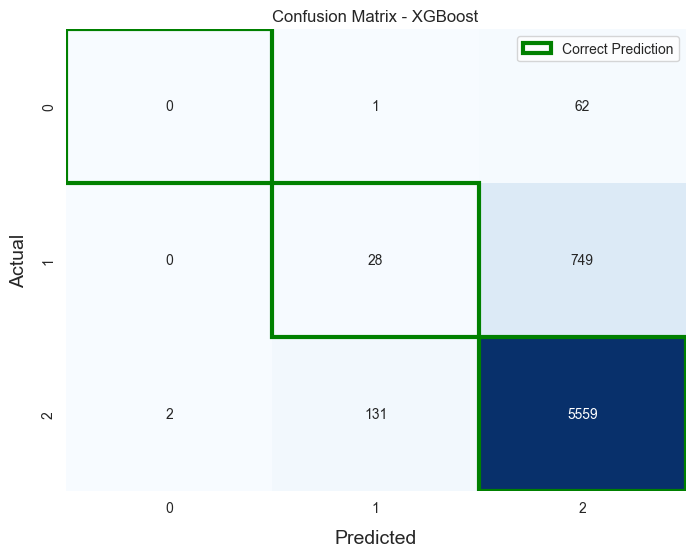

In [39]:
# Print classification report for XGBoost
print("Classification Report - XGBoost")
print(classification_report(y_test, y_pred_xgb))

# Confusion Matrix for XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
cm_df_xgb = pd.DataFrame(cm_xgb, columns=np.unique(y_test), index=np.unique(y_test))
cm_df_xgb.index.name = 'Actual'
cm_df_xgb.columns.name = 'Predicted'
print(cm_df_xgb)

# Plot confusion matrix for XGBoost model
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', cbar=False)

# Replace numbers with class names (Assuming y_test contains the actual class labels)
plt.xticks(ticks=np.arange(len(np.unique(y_test))) + 0.5, labels=np.unique(y_test))
plt.yticks(ticks=np.arange(len(np.unique(y_test))) + 0.5, labels=np.unique(y_test))

# Green border around correct prediction squares
for i in range(len(np.unique(y_test))):
    plt.gca().add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='green', linewidth=3))

plt.legend(['Correct Prediction'], loc='upper right')

plt.xlabel('Predicted', fontsize=14, labelpad=10)
plt.ylabel('Actual', fontsize=14, labelpad=10)
plt.title('Confusion Matrix - XGBoost')
plt.show()

**Summary of XGBoost Model Performance:**
Accuracy: 86%
- Class 0 (Fatal Accidents): The model fails to predict fatal accidents, with both precision and recall at 0.00, leading to an F1-score of 0.00.
- Class 1 (Serious Accidents): Serious accidents are poorly predicted, with precision (0.17) and recall (0.04) very low, resulting in an F1-score of 0.06.
- Class 2 (Slight Accidents): The model performs well on slight accidents, with high precision (0.87), recall (0.98), and an F1-score of 0.92.

Key Issue: The model struggles with predicting fatal and serious accidents due to class imbalance, with most misclassifications happening as slight accidents.

## Addressing Class Imbalance with ChatGPT

One of the key challenges faced during all of the model's development was the class imbalance in the dataset, which severely affected the model's ability to predict fatal (Class 0) and serious (Class 1) accidents. In the dataset, the majority of the instances are for slight accidents (Class 2), while fatal and serious accidents are relatively rare. This imbalance led to a situation where the model predominantly predicted the slight accidents class, resulting in poor precision, recall, and F1-scores for the fatal and serious accidents classes.

To address this issue, I turned to ChatGPT for guidance. 

The following steps were implemented based on ChatGPT’s suggestions:

- SMOTE Application: I incorporated SMOTE within the pipeline to balance the class distribution.
- Imbalanced Pipeline: Since SMOTE is not compatible with standard scikit-learn transformers, I used the ImbPipeline from the imblearn library, which allows for applying resampling techniques like SMOTE within the pipeline.
- Stratified K-Fold Cross-Validation: I used Stratified K-Fold Cross-Validation to ensure each fold maintains the same class distribution as the entire dataset.

Here’s the code that was generated by ChatGPT and implemented to build and train the model:

In [63]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline as ImbPipeline  # Use ImbPipeline for resampling
import pandas as pd

# Define numerical and categorical features
num = ['Latitude', 'Longitude', 'Number_of_Casualties', 'Number_of_Vehicles']
cat = ['Light_Conditions', 'District Area', 'Road_Surface_Conditions', 'Road_Type', 'Urban_or_Rural_Area', 'Vehicle_Type']

# Preprocessor setup for scaling numerical features and one-hot encoding categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num),  # Scale numerical features
        ('cat', OneHotEncoder(), cat)    # One-hot encode categorical features
    ]
)

# XGBoost Classifier without scale_pos_weight (not required for multi-class)
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # Multi-class classification
    num_class=3,  # Adjust based on the number of classes in your target
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    eval_metric='mlogloss',
    random_state=42
)

# Full pipeline with SMOTE for class imbalance handling
XGBoost_Pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing step (scaling + encoding)
    ('smote', SMOTE(random_state=42)),  # Apply SMOTE for class imbalance
    ('xgb', xgb_model)  # XGBoost model
])

# Cross-validation using StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store results for each fold
for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Fit the model on each fold
    XGBoost_Pipeline.fit(X_train_fold, y_train_fold)
    
    # Predict on the validation set
    y_pred_fold = XGBoost_Pipeline.predict(X_val_fold)
    
    # Print classification report for this fold
    print("Classification Report for fold:")
    print(classification_report(y_val_fold, y_pred_fold))

# Once the model is finalized, you can fit it on the entire training set and predict on the test set
XGBoost_Pipeline.fit(X_train, y_train)
y_pred_xgb = XGBoost_Pipeline.predict(X_test)

# Print the final classification report on the test set
print("Final Classification Report on Test Set:")
print(classification_report(y_test, y_pred_xgb))


Classification Report for fold:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.21      0.35      0.26       608
           2       0.90      0.83      0.86      4575

    accuracy                           0.76      5225
   macro avg       0.37      0.39      0.37      5225
weighted avg       0.81      0.76      0.78      5225

Classification Report for fold:
              precision    recall  f1-score   support

           0       0.02      0.02      0.02        42
           1       0.22      0.36      0.27       608
           2       0.90      0.82      0.86      4575

    accuracy                           0.76      5225
   macro avg       0.38      0.40      0.39      5225
weighted avg       0.82      0.76      0.79      5225

Classification Report for fold:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.21      0.37

The model achieves an overall accuracy of 75%, with significant performance disparities across the different classes. It performs well in predicting slight accidents (Class 2), with high precision (0.90) and recall (0.81). However, it struggles with fatal accidents (Class 0), where both precision and recall are very low, leading to almost no correct predictions. For serious accidents (Class 1), the model has moderate performance, with precision around 0.21 and recall at 0.37. The class imbalance remains a key challenge, with the model heavily biased toward predicting the majority class (slight accidents).

# Summary of Results and Next Steps

Despite multiple attempts to address class imbalance and tune the model, the performance of all classifiers, including XGBoost, remains suboptimal for the minority classes (Fatal and Serious accidents). Most models perform reasonably well for predicting Slight accidents but struggle significantly with Fatal and Serious classifications, showing low precision and recall for these categories.

Efforts to address class imbalance through SMOTE, hyperparameter tuning, and class weighting did not yield substantial improvements. The models tend to overpredict the majority class (Slight accidents), leading to high overall accuracy but poor minority class performance.

At this point, further attempts to improve the model have been unsuccessful, and other strategies, such as trying different models (e.g., LightGBM) or ensemble methods, might need to be explored. However, the results suggest that tackling class imbalance and refining model hyperparameters would require a more nuanced approach.